# Logistic Regression Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
print(df['SibSp'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


<AxesSubplot:>

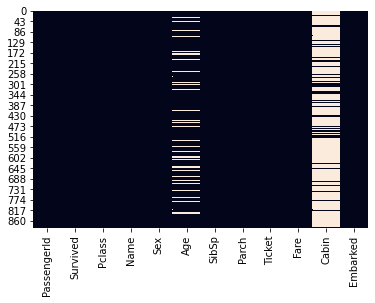

In [3]:
sns.heatmap(df.isnull(), cbar=False)

In [4]:
df['Survived'] = df['Survived'].astype(bool)
df.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
False,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
True,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


In [5]:
survived_mean_age = df['Age'].loc[df['Survived'] == True].mean()
died_mean_age = df['Age'].loc[df['Survived'] == False].mean()

In [6]:
# Setting missing age values to the average of those who died and survived
df['Age'].loc[(df['Survived'] == True) & (df['Age'].isna())] = survived_mean_age
df['Age'].loc[(df['Survived'] == False) & (df['Age'].isna())] = died_mean_age

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

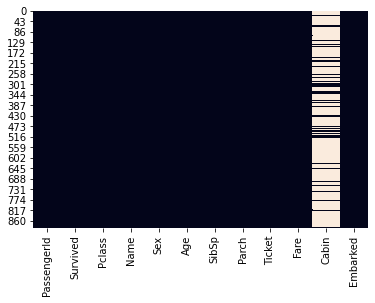

In [7]:
sns.heatmap(df.isnull(), cbar=False)
# I am thinking about dropping the cabin variable, because there are not enough values to determine the missing ones
# But for now I won't use that information to train the model

In [8]:
# saving those changes, so that I do not have to do that again.
df.to_csv('../data/processed_titanic.csv')

# Training the model

In [9]:
# Additional transformation of Sex variable to be done: female (1) and male(0)
df['Sex'].loc[df['Sex'] == 'male'] = 0.0
df['Sex'].loc[df['Sex'] == 'female'] = 1.0

In [38]:
# Define X and y
X = df[['Pclass', 'Sex', 'Age', 'Fare']]
y = df['Survived']

In [39]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
# Initialize model
model = LogisticRegression()

# Train the model with test data
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Evaluating the model
y_pred_test = model.predict(X_test)

accuracy_score(y_test, y_pred_test)

0.7668161434977578

## Get a bunch metrics for model (confusion matrix)

In [69]:
from sklearn import metrics

In [70]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[117,  20],
       [ 24,  62]])

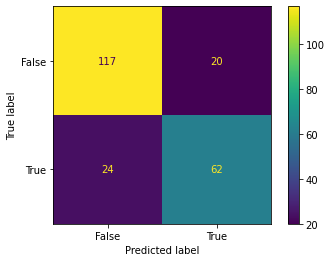

In [71]:
metrics.plot_confusion_matrix(model, X_test, y_test)

In [72]:
metrics.precision_score(y_test, y_pred_test)

0.7560975609756098

In [73]:
metrics.recall_score(y_test, y_pred_test)

0.7209302325581395

In [74]:
metrics.f1_score(y_test, y_pred_test)

0.7380952380952381

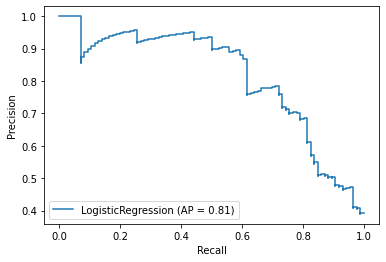

In [76]:
metrics.plot_precision_recall_curve(model, X_test, y_test)

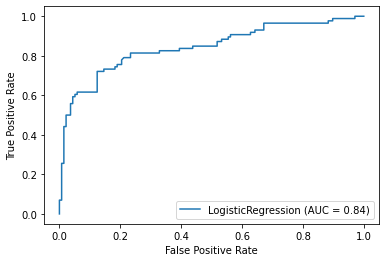

In [77]:
metrics.plot_roc_curve(model, X_test, y_test)

# Feature Engineering:

1. Age => binning
2. Fare => scaling
3. names => extract titles (-gender), hotencode 

In [46]:
from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

In [60]:
# I already imputed the missing Age values manually. That is why i skip that for now. Might include that later.
# I have to repeat that step because i did the imputation before splitting the dataset

kbins = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile') # try out different strategies

In [61]:
kbins.fit(X[['Age']])
t = kbins.transform(X[['Age']])
print(kbins.bin_edges_ , t)

[array([ 0.42, 22.  , 30.  , 35.  , 80.  ])] [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [62]:
df_bins = pd.DataFrame(t)
df_bins.sum()

0    204.0
1    232.0
2    220.0
3    235.0
dtype: float64

In [312]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = MinMaxScaler()
scaler.fit(X[['Fare']])
f = scaler.transform(X[['Fare']])

In [313]:
feat_eng = ColumnTransformer(
    transformers = [
        ('fare_scaler', MinMaxScaler(), ['Fare']),
        ('age_binner', KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense', strategy = 'quantile'), ['Age'])
        # Add titles later
    ],
    remainder = 'passthrough'
)

In [314]:
feat_eng.fit(X_train)

X_train_trans = feat_eng.transform(X_train)
X_train_trans.shape

(668, 8)

In [315]:
model.fit(X_train_trans, y_train)

LogisticRegression()

In [316]:
X_test_trans = feat_eng.transform(X_test)

y_pred = model.predict(X_test_trans)

accuracy_score(y_test, y_pred)

0.8385650224215246

# Titles

1. Try to extract titles from names,
2. Magic

In [325]:
df.loc[df['Name'].str.contains('Mrs.') ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,38.0,1,0,PC 17599,71.2833,C85,C
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,35.0,1,0,113803,53.1000,C123,S
8,9,True,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1.0,27.0,0,2,347742,11.1333,NaN,S
9,10,True,2,"Nasser, Mrs. Nicholas (Adele Achem)",1.0,14.0,1,0,237736,30.0708,NaN,C
15,16,True,2,"Hewlett, Mrs. (Mary D Kingcome)",1.0,55.0,0,0,248706,16.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,True,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",1.0,47.0,1,1,11751,52.5542,D35,S
874,875,True,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",1.0,28.0,1,0,P/PP 3381,24.0000,NaN,C
879,880,True,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",1.0,56.0,0,1,11767,83.1583,C50,C
880,881,True,2,"Shelley, Mrs. William (Imanita Parrish Hall)",1.0,25.0,0,1,230433,26.0000,NaN,S


In [335]:
titles = df['Name'].str.extract(',\s(\w+)\.')

In [340]:
titles.value_counts()

# Mlle = Mademoiselle == Miss
# Jonkheer = Adelstitel
# Mme = Madame == Mrs
# Ms = Miss 

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Don           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Sir           1
dtype: int64

- grouping into 5 different groups = (Mr, Miss, Mrs, Master, rest). 
- This means I have to rename `Mlle` and `Ms` to `Miss` and `Mme` to `Mrs`.
- Also `Dr`, `Rev`, `Col`, `Major`, `Capt`, `Jonkheer`, `Lady` and `Sir` need to be renames to `rest`

In [348]:
df['titles'] = titles.replace({'Mlle': 'Miss', 
                     'Ms': 'Miss', 
                     'Mme': 'Mrs', 
                     'Dr': 'rest', 
                     'Don': 'rest',
                     'Rev': 'rest', 
                     'Col': 'rest', 
                     'Major': 'rest', 
                     'Capt': 'rest', 
                     'Jonkheer': 'rest', 
                     'Lady': 'rest', 
                     'Sir': 'rest'})

In [347]:
t2.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
rest       22
dtype: int64

In [349]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,titles
0,1,False,3,"Braund, Mr. Owen Harris",0.0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,True,3,"Heikkinen, Miss. Laina",1.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,False,3,"Allen, Mr. William Henry",0.0,35.0,0,0,373450,8.0500,NaN,S,Mr
